In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
from keras import initializers
import os
import keras
from keras import layers
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
X_train = X_train[y_train.flatten() == 3]

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
def visualize_rgb(img):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")
    plt.show()

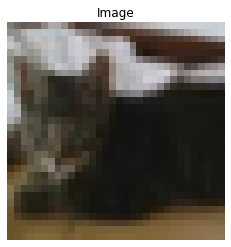

In [5]:
visualize_rgb(X_train[0])

In [0]:
img_rows = 32
img_cols = 32
channels = 3      
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100  

In [0]:
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

generator = Sequential()

generator.add(Dense(2*2*512, input_shape=(latent_dim,), activation='relu', kernel_initializer=init))
generator.add(BatchNormalization())
generator.add(Reshape((2, 2, 512)))

generator.add(Conv2DTranspose(256, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(128, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer=init, strides=2, padding='same'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same',kernel_initializer=init,
                              activation='tanh'))

In [8]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         1179904   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)        

In [0]:
img_shape = X_train[0].shape

discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=3, strides=2, use_bias=False, padding='valid',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128, kernel_size=3, strides=2,  kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(256, kernel_size=3, strides=2, kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# discriminator.add(Flatten())
discriminator.add(GlobalAveragePooling2D())

discriminator.add(Dense(1, activation='sigmoid'))

In [10]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 64)        1728      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73728     
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 256)        

In [0]:
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

In [0]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
gan_model = Model(inputs=z, outputs=decision)

gan_model.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [0]:
def normalize(img):
    return (img - 127.5) / 127.5

In [0]:
def denormalize(img):
    img = (img * 127.5) + 127.5
    return img.astype(np.uint8)

In [15]:
print(X_train.shape)

(5000, 32, 32, 3)


In [0]:
X_train = normalize(X_train)

iterations = 5000
batch_size = 20
save_dir = os.path.join("./", 'gan_images')

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [17]:
epochs = 1000
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        discriminator.trainable = True

        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
    
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        d_loss_batch = (d_loss_real[0] + d_loss_fake[0])
        
        discriminator.trainable = False
        g_loss_batch = gan_model.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])

    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 3 == 0:
      gan_model.save_weights('gan.h5')

      img = image.array_to_img(denormalize(X_fake[0]), scale=False)
      img.save(os.path.join(save_dir, 'generated' + str(e) + '.png'))

      img = image.array_to_img(denormalize(X_batch[0]), scale=False)
      img.save(os.path.join(save_dir, 'real' + str(e) + '.png'))
       

epoch = 1/1000, d_loss=0.486, g_loss=0.162                                                                                                     
epoch = 2/1000, d_loss=0.472, g_loss=0.157                                                                                                     
epoch = 3/1000, d_loss=1.206, g_loss=0.813                                                                                                     
epoch = 4/1000, d_loss=1.371, g_loss=0.988                                                                                                     
epoch = 5/1000, d_loss=1.284, g_loss=0.896                                                                                                     
epoch = 6/1000, d_loss=1.250, g_loss=0.906                                                                                                     
epoch = 7/1000, d_loss=1.352, g_loss=0.923                                                                                              